In [348]:
%matplotlib inline
from functools import partial
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.autograd import Variable

In [497]:
class RNN(nn.Module):
    
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        
        self.hidden_size = hidden_size
        
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        
    def forward(self, input, hidden):
        
        combined = torch.cat((input, hidden), 1)
        
        hidden = self.i2h(combined)
        output = self.i2o(combined)
            
        return output, hidden
    
    def initHidden(self):
        return torch.zeros(1, self.hidden_size)
    

In [3]:
def makeData(npoints = 500, f = None):
    
    if f is None:
        f = lambda x: x*x + 10
    
    x = np.linspace(0, 10*np.pi, npoints)
    
    y = np.array(list(map(f, x)))
    
    x = torch.Tensor(x).view(-1, 1)
    y = torch.Tensor(y).view(-1, 1)
    
    return x, y

In [60]:
def loadData(filename, npoints = 100):
    
    df = pd.read_json(filename, orient = 'values')
    
    y = torch.Tensor(df.values)[:npoints]
    
    return y

In [49]:
def sequence_train_test_split(sequence, test = 0.2):
    
    n = len(sequence)
    
    indices = np.arange(n)
    
    train_split = 1 - test
    ntrain = int(n * train_split)
    
    train_indices, test_indices = indices[:ntrain], indices[ntrain:]
    
    train_sequence = sequence[train_indices]
    test_sequence = sequence[test_indices]
    
    train_input = train_sequence[:-1].unsqueeze(2)
    train_target = train_sequence[1:]
    
    test_input = test_sequence[:-1].unsqueeze(2)
    test_target = test_sequence[1:]
    
    return train_input, test_input, train_target, test_target

In [375]:
def train(rnn, train_input, train_target, lr = 0.001, epochs = 1000, teacher_forcing_ratio = 0.5, plot = True):
    
    criterion = nn.MSELoss()
    optimizer = optim.Adam(rnn.parameters(), lr = lr)
    
    try:
        for epoch in range(epochs):

            hidden = rnn.initHidden()
            
            use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False
            
            loss = 0
            outputs = []
            
            if use_teacher_forcing:
            
                for i, input in enumerate(train_input):
                    output, hidden = rnn(input, hidden)
                    outputs.append(output)
                    
                    l = criterion(output, train_target[i])
                    loss += l
            
            else:
                
                output = train_input[0]
                
                for i in range(len(train_target)):
                    output, hidden = rnn(output, hidden)
                    outputs.append(output)
                    
                    l = criterion(output, train_target[i])
                    loss += l
                    
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if epoch % 25 == 0:
                print('epoch {}, loss {}, teacher forcing: {}'.format(epoch, loss, use_teacher_forcing))
            
            
            
    except KeyboardInterrupt:
        pass
    
    if plot:
        
        hidden = rnn.initHidden()
        outputs = []
        
        for i, input in enumerate(train_input):
            output, hidden = rnn(input, hidden)
            outputs.append(output)
        
        pred_target = torch.Tensor(outputs).view(-1,1)
        
        with torch.no_grad():
            t = np.arange(train_input.size(0))

            plt.plot(t, pred_target.detach().numpy(), color = 'red', linewidth = 2)
            plt.plot(t, train_target.detach().numpy(), color = 'blue', linewidth = 1)
            
    return rnn

In [422]:
def predict(rnn, train_input, train_target, test_input, test_target, future = 50, plot = True):
    
    hidden = rnn.initHidden()

    training_outputs = []
    for input in train_input:
        output, hidden = rnn(input, hidden)
        training_outputs.append(output)
        
    pred_train_target = torch.Tensor(training_outputs).view(-1,1)
      
    testing_outputs = []   
    for i, input in enumerate(test_input):
        output, hidden = rnn(input, hidden)
        testing_outputs.append(output)
        
    pred_test_target = torch.Tensor(testing_outputs).view(-1,1)
    
    future_targets = []
    for _ in range(future):
        output, hidden = rnn(output, hidden)
        future_targets.append(output)
      
    pred_future_target = torch.Tensor(future_targets).view(-1,1)
        
    
    if plot:
        
        with torch.no_grad():
            t1 = np.arange(pred_train_target.size(0))
            t2 = np.arange(len(t1), len(t1) + pred_test_target.size(0))
            t3 = np.arange(len(t1) + len(t2), len(t1) + len(t2) + pred_future_target.size(0))
            
            s = 50
            plt.plot(t1[s:], pred_train_target.numpy()[s:], color = 'red', linewidth = 2, label = 'Train Prediction')
            plt.plot(t1[s:], train_target.numpy()[s:], color = 'blue', linewidth = 1, label = 'Train True')
            
            plt.plot(t2, pred_test_target.numpy(), color = 'red', linewidth = 2, linestyle = '--', label = 'Test Prediction')
            plt.plot(t2, test_target.numpy(), color = 'blue', linewidth = 1, linestyle = '--', label = 'Test True')
            
            plt.plot(t3, pred_future_target.numpy(), color = 'green', linewidth = 2, label = 'Future Prediction')
            
            plt.legend(bbox_to_anchor=(1.04,0.5), loc="center left", borderaxespad=0)

In [518]:
def predictV2(rnn, y, future = 50, plot = True):
    
    hidden = rnn.initHidden()
    
    input_y = y[:-1]
    target_y = y[1:]
    
    outputs = []
    for input in input_y.view(-1,1,1):
        output, hidden = rnn(input, hidden)
        outputs.append(output)
        
    future_outputs = [output]
    for _ in range(future):
        output, hidden = rnn(output, hidden)
        future_outputs.append(output)
        
    all_outputs = outputs + future_outputs
    
    pred_target_y = torch.Tensor(outputs).view(-1, 1)
    future_target_y = torch.Tensor(future_outputs).view(-1, 1)
    
    all_target_y = torch.Tensor(all_outputs).view(-1, 1)
    
    if plot:
        with torch.no_grad():
            t1 = np.arange(len(input_y))
            t2 = np.arange(len(input_y) - 1, len(input_y) - 1 + len(future_outputs))
            
            plt.plot(t1, target_y.detach().numpy(), label = 'Past True', color = 'blue')
            plt.plot(t1, pred_target_y.detach().numpy(), label = 'Past Prediction', color = 'red')
            
            plt.plot(t2, future_target_y.detach().numpy(), linestyle = '--', color = 'red', label = 'Future Prediction')
            
            plt.legend(bbox_to_anchor=(1.04,0.5), loc="center left", borderaxespad=0)
            
    return future_target_y

In [528]:
a, b, c = -5, 256, 240

In [534]:
256 & 255

0

In [533]:
(d ^ a) >> 32

-1

In [498]:
n_input = 1
n_hidden = 128
n_output = 1
rnn = RNN(n_input, n_hidden, n_output)

In [499]:
npoints = 100
f = lambda x: np.sin(x)
_, y = makeData(npoints=npoints, f = f)
#y = loadData('ml_input_foo.json', npoints = npoints)

In [511]:
y.size()

torch.Size([100, 1])

In [500]:
print(y.shape)

torch.Size([100, 1])


In [501]:
train_input, test_input, train_target, test_target= sequence_train_test_split(y)

In [502]:
print(train_input.size())
print(train_target.size())

torch.Size([79, 1, 1])
torch.Size([79, 1])


In [503]:
print(test_input.size())
print(test_target.size())

torch.Size([19, 1, 1])
torch.Size([19, 1])


epoch 0, loss 9.206915855407715, teacher forcing: True
epoch 25, loss 0.5446184873580933, teacher forcing: True
epoch 50, loss 0.3366454243659973, teacher forcing: True
epoch 75, loss 0.22036288678646088, teacher forcing: True
epoch 100, loss 0.17428971827030182, teacher forcing: True
epoch 125, loss 0.1462259739637375, teacher forcing: True
epoch 150, loss 0.12557624280452728, teacher forcing: True
epoch 175, loss 0.10957848280668259, teacher forcing: True
epoch 200, loss 0.09688019752502441, teacher forcing: True
epoch 225, loss 0.0865822359919548, teacher forcing: True
epoch 250, loss 0.0780688226222992, teacher forcing: True
epoch 275, loss 0.0709114670753479, teacher forcing: True


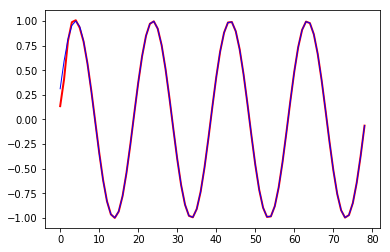

In [506]:
rnn = train(rnn, train_input, train_target, lr = 0.0003, epochs=1000, teacher_forcing_ratio=1)

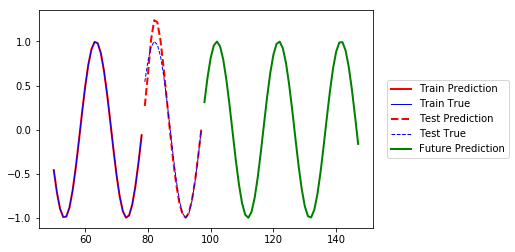

In [507]:
predict(rnn, train_input, train_target, test_input, test_target, future = 50)

In [520]:
y.size()

torch.Size([100, 1])

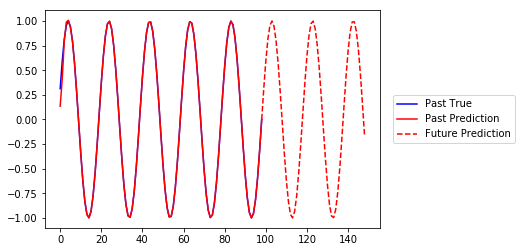

In [519]:
predictV2(rnn, y)

In [551]:
def breadthFirst(current_node, d, graph):
    if d == 0:
        print(current_node)
    
    if current_node not in graph:
        return
    
    for neighbor in graph[current_node]:
        breadthFirst(neighbor, d-1, graph)

def helper(node, graph, k):
    for d in range(k):
        breadthFirst(node, d, graph)


In [535]:
graph = {1: (2, 3), 2: (4, 5), 3: (6, 7)}

In [554]:
k = 3
helper(1, graph, k)

1
2
3
4
5
6
7


In [556]:
def foo(lis):
    if lis == []:
        return
    else:
        print(lis[0])
        foo(lis[1:])

In [558]:
foo([1,2,3,4])

1
2
3
4


In [559]:
num2let = {0: 'abc', 1: 'def'}
telNum = [0, 1]

def printTelephoneNumbers(num2let, acc, telNum):
    if telNum == []:
        print(acc)
    else:
        letters = num2let[telNum[0]]
        for letter in letters:
            printTelephoneNumbers(num2let, acc + letter, telNum[1:])


In [560]:
printTelephoneNumbers(num2let, "", telNum)

ad
ae
af
bd
be
bf
cd
ce
cf


In [561]:
adamData = pd.read_json("oura_2019-03-05T18-00-21.json")

ValueError: arrays must all be same length